In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tqdm

In [2]:
def mass_spring_damper_multi_freq(Zeta, M, K, Gamma, Tspan,
                                  V_Sin: tuple, V_Cos: tuple, Freq_d: tuple):
    # zeta: damping ratio
    # omega_n: natural frequency
    # gamma: forcing amplitude
    # tspan: time span
    # V_Sin: sin component of the initial voltage
    # V_Cos: cos component of the initial voltage
    # Freq_d: forcing frequency
    # returns: time, velocity, displacement
    omega_n = (K / M) ** 0.5
    Omega_d = np.array(Freq_d) * 2 * np.pi
    Vi = np.vectorize(lambda t: np.array(V_Sin) @ np.sin(Omega_d * t) +
                                np.array(V_Cos) @ np.cos(Omega_d * t))
    F_vol = lambda t: Gamma * Vi(t)

    #
    def mass_spring_damper(t, y):
        return np.array([y[1], -omega_n ** 2 * y[0] - 2 * Zeta * omega_n * y[1] + F_vol(t) / M])

    # solve the ODE
    sol = sp.integrate.solve_ivp(mass_spring_damper, [Tspan[0], Tspan[-1]], [0, 0], t_eval=Tspan)
    # 
    return sol.t, sol.y, Vi(sol.t)

In [3]:
# define the parameters
Epoch = 250
zeta = 0.01  # damping ratio
m = 1E-1  # mass
k = 1E+5  # spring constant
B = 1E0  # coupling coefficient
C = 1E-7  # capacitance
v1 = [+10, +5, +2]  # initial voltage sin component
v2 = [-5, -6, 0]  # initial voltage cos component
u1, u2 = [2.5E-4, 1.0E-4, 0.6E-4], [.0E-4, .0E-4, .0E-4]  # initial displacement
freq_d = [3, 7, 16]  # forcing frequency
tspan = np.linspace(0, 2, 1000)  # time span
lr = 3E+3  # learning rate
#
Xt = np.vectorize( lambda t: np.array(u1) @ np.sin(np.array(freq_d) * 2 * np.pi * t) + \
                    np.array(u2) @ np.cos(np.array(freq_d) * 2 * np.pi * t) ) (tspan)
#

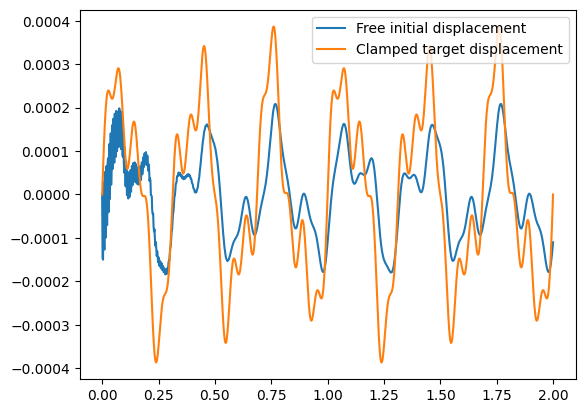

In [4]:

T, U, V = mass_spring_damper_multi_freq(zeta, m, k, B, tspan, v1, v2, freq_d)
V0 = V.copy()
plt.plot(T, U[0], label='Free initial displacement')
plt.plot(T, Xt, label='Clamped target displacement')
plt.legend()
plt.show()


In [5]:
V1, V2 = [], []
for e in tqdm.tqdm(range(Epoch)):
    T, U, V = mass_spring_damper_multi_freq(zeta, m, k, B, tspan, v1, v2, freq_d)
    N = int(len(T)/2)
    Q_free = B * U[0, N:] + C * V[N:]
    #
    Q_free_sin = np.zeros(len(freq_d))
    Q_free_cos = np.zeros(len(freq_d))
    for i in range(len(freq_d)):
        Q_free_sin[i] = 2 * Q_free @ np.sin(freq_d[i] * 2 * np.pi * T[N:]) / len(T[N:])
        Q_free_cos[i] = 2 * Q_free @ np.cos(freq_d[i] * 2 * np.pi * T[N:]) / len(T[N:])
    #
    Q_clamped = B * Xt[N:] + C * V[N:]
    Q_clamped_sin = np.zeros(len(freq_d))
    Q_clamped_cos = np.zeros(len(freq_d))
    for i in range(len(freq_d)):
        Q_clamped_sin[i] = 2 * Q_clamped @ np.sin(freq_d[i] * 2 * np.pi * T[N:]) / len(T[N:])
        Q_clamped_cos[i] = 2 * Q_clamped @ np.cos(freq_d[i] * 2 * np.pi * T[N:]) / len(T[N:])
    #
    v1 = v1 + lr * (Q_clamped_sin - Q_free_sin)
    v2 = v2 + lr * (Q_clamped_cos - Q_free_cos)
    V1.append(v1)
    V2.append(v2)

Vf = V.copy()
    

100%|██████████| 250/250 [00:44<00:00,  5.57it/s]


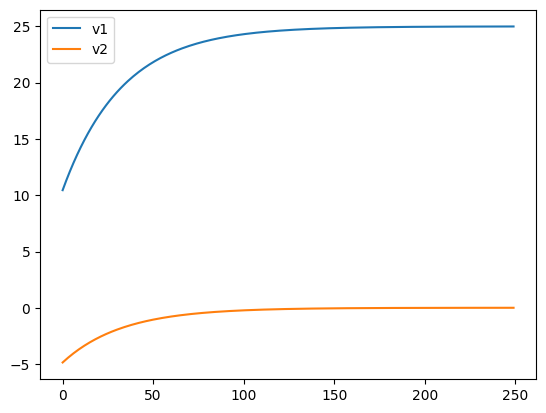

In [6]:
V1 = np.array(V1)
V2 = np.array(V2)
plt.plot(V1[:, 0], label='v1')
# plt.text(200, v1, 'v1 = {:.2f}'.format(v1))
plt.plot(V2[:, 0], label='v2')
# plt.text(200, v2, 'v2 = {:.2f}'.format(v2))
plt.legend()

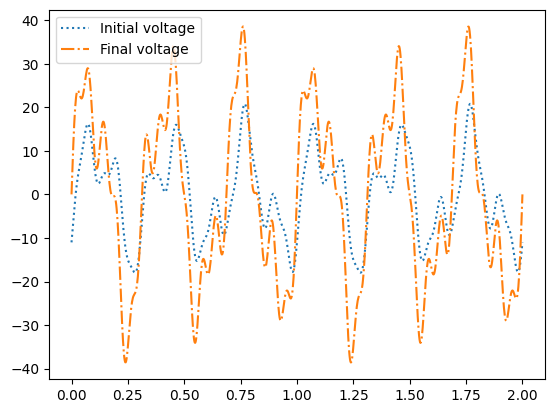

In [7]:
plt.plot(T, V0, label='Initial voltage', linestyle=':')
plt.plot(T, Vf, label='Final voltage', linestyle='-.')
plt.legend()
plt.show()

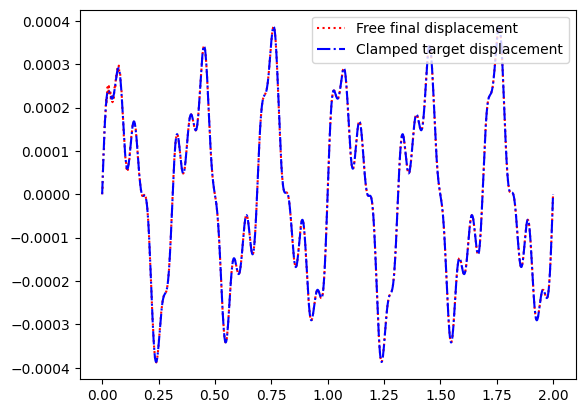

In [8]:
plt.plot(T, U[0], label='Free final displacement', linestyle=':', color='red')
plt.plot(T, Xt, label='Clamped target displacement', linestyle='-.', color='blue')
plt.legend()